In [1]:
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import time
import copy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys

import torch_geometric
import itertools
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GCNConv, GATv2Conv
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax, get_laplacian, to_dense_adj
from my_gat import my_GATConv
from my_mlp_gat import my_MLP_GATConv
sys.path.insert(0, os.path.abspath('../../'))
from torch_geometric.datasets import Planetoid

import torch.nn.functional as F # <-- Remove

# Data function

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
datasets = [Planetoid(root='data/CiteSeer/', name='CiteSeer'), Planetoid(root='data/Cora/', name='Cora'),Planetoid(root='data/PubMed/', name='PubMed')]

# Setup models

In [4]:
class Eigen(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.k = k
    
    def forward(self, edge_idx):
        lap_idx, lap_wt = get_laplacian(edge_idx, normalization="sym")
        lap_adj = to_dense_adj(lap_idx)
        eigenvals, eigenvecs = torch.linalg.eig(lap_adj)
        top_eig = eigenvecs.squeeze(0)[:, 1:self.k+1]
        top_eig = torch.real(top_eig)
        new_edge_features = torch.Tensor(edge_idx.size(1), 2 * self.k).to(edge_idx.device)
        new_edge_idx = edge_idx.T

        for idx, pair in enumerate(new_edge_idx):
            i, j = pair
            x_i_prime = top_eig[i]
            x_j_prime = top_eig[j]
            new_feat = torch.cat([x_i_prime, x_j_prime], dim=0)
            new_edge_features[idx] = new_feat

        return new_edge_features

class Model_GAT(torch.nn.Module):
    def __init__(self, d, out_d, K):
        super(Model_GAT, self).__init__()
        
        self.conv1 = my_GATConv(d, out_d, heads=K)
#         self.conv1 = GATv2Conv(d, out_d, heads=K, concat=False, share_weights=True)
#         self.conv1 = my_MLP_GATConv(d, out_d, 2, 100, share_weights=True)

    def forward(self, data):
        
        # 1. Obtain node embeddings 
        x = data.x
        x, attn_weights, pair_pred = self.conv1(x, data.edge_index, return_attention_info=True)
        
        return x.squeeze(-1), attn_weights, pair_pred
    
class Model_MLP_GAT(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_MLP_GAT, self).__init__()
        
        self.eigen = Eigen(2)
        self.conv1 = my_MLP_GATConv(
            in_channels=d, 
            out_channels=out_d,
            att_in_channels=2,
            att_out_channels=4,
            share_weights=True, 
            bias=False
        )

    def forward(self, data):
        
        # 1. Obtain node embeddings 
        x = data.x
        eigen_x = self.eigen(data.edge_index)
        x, attn_weights, pair_pred = self.conv1(x, data.edge_index, edge_attr=eigen_x, return_attention_info=True)
        
        return x.squeeze(-1), attn_weights, pair_pred
    
class Model_GCN(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_GCN, self).__init__()
        
        self.conv1 = GCNConv(d,out_d, bias=False)

    def forward(self, data):
        
        # 1. Obtain node embeddings 
        x = data.x
        x = self.conv1(x, data.edge_index)
        
        return x.squeeze(-1)
    
class Model_linear(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_linear, self).__init__()
        
        self.linear = torch.nn.Linear(d,out_d, bias=False)

    def forward(self, data):
        
        # 1. Obtain node embeddings 
        x = data.x
        x = self.linear(x)
        
        return x.squeeze(-1)

## Setup train and accuracy functions

In [5]:
@torch.no_grad()
def measure_accuracy(model, data):
    model.eval()
         
    logits = model(data) # forward operation
    preds = torch.sigmoid(logits) > 0.5
    
    # calculate training accuracy
    correct = preds[data.train_mask] == data.ynew[data.train_mask]
    train_acc = int(correct.sum()) / int(data.train_mask.sum())
    
    # calculate training accuracy
    correct = preds[data.test_mask] == data.ynew[data.test_mask]
    test_acc = int(correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, test_acc

## Setup MLP GAT and GAT

In [6]:
@torch.no_grad()
def measure_accuracy_gat(model, data):
    model.eval()
         
    logits, attn_weights, pair_pred = model(data) # forward operation
    preds = torch.sigmoid(logits) > 0.5
    
    # calculate training accuracy
    correct = preds[data.train_mask] == data.ynew[data.train_mask]
    train_acc = int(correct.sum()) / int(data.train_mask.sum())
    
    # calculate training accuracy
    correct = preds[data.test_mask] == data.ynew[data.test_mask]
    test_acc = int(correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, test_acc, attn_weights, pair_pred

## Utility functions

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def info_mlp_gat(attn_weights, idx, head):
    intra_weight = []
    idx_intra = []
    inter_weight = []
    idx_inter = []

    weights = attn_weights[1]

    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)) or ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight.append(weights[i].item())
            idx_intra.append(i)
        else:
            inter_weight.append(weights[i].item())
            idx_inter.append(i)
    return intra_weight, idx_intra, inter_weight, idx_inter

def info_gat(attn_weights, idx, head):
    intra_weight = [[],[]]
    idx_intra = [[],[]]
    inter_weight = [[],[]]
    idx_inter = [[],[]]

    weights = attn_weights[1][:,head]
    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)):
            intra_weight[0].append(weights[i].item())
            idx_intra[0].append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight[1].append(weights[i].item())
            idx_intra[1].append(i)
        elif ((edge[0] in idx_class0) and (edge[1] in idx_class1)):
            inter_weight[0].append(weights[i].item())
            idx_inter[0].append(i)
        else: 
            inter_weight[1].append(weights[i].item())
            idx_inter[1].append(i)
            
    return intra_weight, idx_intra, inter_weight, idx_inter

def my_plot_violin(intra_weight, inter_weight):
    plt.figure(figsize=(10, 6), dpi=80)
    ww_intra = np.ones_like(intra_weight)/len(intra_weight)
    ww_inter = np.ones_like(inter_weight)/len(inter_weight)
#     plt.hist(intra_weight, bins=500, weights=ww_intra, alpha=0.9, label='Intra')
#     plt.hist(inter_weight, bins=500, weights=ww_inter, alpha=0.6, label='Inter')
    pos = [1, 1.5]
    plt.violinplot([intra_weight, inter_weight], pos, points=20, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=False)
    plt.legend(loc='upper right')
    plt.yscale('linear')
    plt.show()
    
def pair_acc(n_edges, pair_pred, idx_intra, idx_inter, head):
    
    tmp = torch.zeros(n_edges).to(device)
    tmp[pair_pred[:,head].reshape(len(pair_pred)) > 0] = 1

    gt = torch.zeros(n_edges).to(device)
    gt[idx_intra] = 1

    acc_intra_edges = 1 - torch.sum(torch.abs(gt[idx_intra] - tmp[idx_intra]))/len(idx_intra)
    acc_inter_edges = 1 - torch.sum(torch.abs(gt[idx_inter] - tmp[idx_inter]))/len(idx_inter)
    print("Head: ", head, " acc intra edges: ", acc_intra_edges.item(), " acc inter edges: ", acc_inter_edges.item())
    
    return acc_intra_edges, acc_inter_edges

def my_plot(name, which_class, heads, mus, degree, intra_gamma, inter_gamma, intra_gamma_, inter_gamma_, 
            intra_gamma_std, inter_gamma_std, intra_gamma_std_, inter_gamma_std_, 
            test_acc_mlp_gat, test_acc_gat, test_acc_gcn, test_acc_lin, 
            acc_intra_edges_all, acc_inter_edges_all, acc_intra_edges_all_, acc_inter_edges_all_):
    
    mus = mus.cpu()
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,intra_gamma, linewidth=2, linestyle='-', marker='*', markersize=9, label='Average $\gamma$, intra edges, MLP-GAT')
#     plt.fill_between(mus,np.asarray(intra_gamma)-np.asarray(intra_gamma_std),np.asarray(intra_gamma)+np.asarray(intra_gamma_std),alpha=0.4)

    plt.plot(mus,inter_gamma, linewidth=2, linestyle='-', marker='X', markersize=9, label='Average $\gamma$, inter edges, MLP-GAT')
#     plt.fill_between(mus,np.asarray(inter_gamma)-np.asarray(inter_gamma_std),np.asarray(inter_gamma)+np.asarray(inter_gamma_std),alpha=0.4)
    
    d_mean = (1+degree).mean().cpu()
#     inv_d_std = (1/(1+degree)).std().cpu()
    inv_degree_mean_vec = (1/d_mean)*np.ones(len(mus))
    
    plt.plot(mus,inv_degree_mean_vec, linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Average $1/|N_i|$')
#     plt.fill_between(mus,inv_degree_mean_vec-inv_d_std,inv_degree_mean_vec+inv_d_std,alpha=0.4)

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('$\gamma$ value', fontsize=20)
    plt.show()
    
    fig.savefig("figures/gammas_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+".pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,intra_gamma_std, linewidth=2, linestyle='-', marker='*', markersize=9, label='Stand. dev. $\gamma$, intra edges, MLP-GAT')

    plt.plot(mus,inter_gamma_std, linewidth=2, linestyle='-', marker='X', markersize=9, label='Stand. dev. $\gamma$, inter edges, MLP-GAT')
    
#     d_mean = (1+degree).mean().cpu()
    inv_d_std = (1/(1+degree)).std().cpu()
#     inv_degree_mean_vec = (1/d_mean)*np.ones(len(mus))
    
    plt.plot(mus,inv_d_std*np.ones(len(mus)), linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Stand. dev. of $1/|N_i|$')

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.show()
    
    fig.savefig("figures/gammas_std_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+".pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(16, 12), dpi=80)

    marker_intra = ['v','^','>','<']
    marker_inter = ['1','2','3','4']

    ct = 0
    for head in range(heads):
        for class_ in range(2):
            plt.plot(mus,intra_gamma_[head][class_], linewidth=2, linestyle='-', marker=marker_intra[ct], markersize=9, label='Average $\gamma$, intra edges, GAT'+', head '+str(head) + ", class " + str(class_))
#             plt.fill_between(mus,np.asarray(intra_gamma_[head][class_])-np.asarray(intra_gamma_std_[head][class_]),np.asarray(intra_gamma_[head][class_])+np.asarray(intra_gamma_std_[head][class_]),alpha=0.4)

            plt.plot(mus,inter_gamma_[head][class_], linewidth=2, linestyle='-', marker=marker_inter[ct], markersize=9, label='Average $\gamma$, inter edges, GAT'+', head '+str(head) + ", class " + str(class_))
#             plt.fill_between(mus,np.asarray(inter_gamma_[head][class_])-np.asarray(inter_gamma_std_[head][class_]),np.asarray(inter_gamma_[head][class_])+np.asarray(inter_gamma_std_[head][class_]),alpha=0.4)
            ct += 1
    
    d_mean = (1+degree).mean().cpu()
#     inv_d_std = (1/(1+degree)).std().cpu()
    inv_degree_mean_vec = (1/d_mean)*np.ones(len(mus))
    
    plt.plot(mus,inv_degree_mean_vec, linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Average $1/|N_i|$')
#     plt.fill_between(mus,inv_degree_mean_vec-inv_d_std,inv_degree_mean_vec+inv_d_std,alpha=0.4)

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('$\gamma$ value', fontsize=20)
    
    fig.savefig("figures/gammas_GAT_real_data_ansatz_"+name+"_class_"+str(which_class)+".pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(16, 12), dpi=80)

    ct = 0
    for head in range(heads):
        for class_ in range(2):
            plt.plot(mus,intra_gamma_std_[head][class_], linewidth=2, linestyle='-', marker=marker_intra[ct], markersize=9, label='Stand. dev. $\gamma$, intra edges, GAT'+', head '+str(head) + ", class " + str(class_))
            plt.plot(mus,inter_gamma_std_[head][class_], linewidth=2, linestyle='-', marker=marker_inter[ct], markersize=9, label='Stand. dev. $\gamma$, inter edges, GAT'+', head '+str(head) + ", class " + str(class_))
            ct += 1

    
    plt.plot(mus,inv_d_std*np.ones(len(mus)), linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Stand. dev. $1/|N_i|$')

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('$\gamma$ value', fontsize=20)
    
    fig.savefig("figures/gammas_std_GAT_real_data_ansatz_"+name+"_class_"+str(which_class)+".pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,test_acc_mlp_gat, linewidth=2, linestyle='-', marker='*', markersize=9, label='MLP-GAT')
#     plt.plot(mus,test_acc_gat, linewidth=2, linestyle='-', marker='X', markersize=9, label='GAT')
    plt.plot(mus,test_acc_gcn, linewidth=2, linestyle='-', marker='s', markersize=9, label='GCN')
    plt.plot(mus,test_acc_lin, linewidth=2, linestyle='-', marker='D', markersize=9, color = 'purple', label='No-graph')

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Classification accuracy', fontsize=20)
    plt.show()
    
    fig.savefig("figures/node_classification_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+".pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(16, 12), dpi=80)

#     plt.plot(mus,test_acc_mlp_gat, linewidth=2, linestyle='-', marker='*', markersize=9, label='MLP-GAT')
    plt.plot(mus,test_acc_gat, linewidth=2, linestyle='-', marker='X', markersize=9, label='GAT')
    plt.plot(mus,test_acc_gcn, linewidth=2, linestyle='-', marker='s', markersize=9, label='GCN')
    plt.plot(mus,test_acc_lin, linewidth=2, linestyle='-', marker='D', markersize=9, color = 'purple', label='No-graph')

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Classification accuracy', fontsize=20)
    plt.show()
    
    fig.savefig("figures/node_classification_GAT_real_data_ansatz_"+name+"_class_"+str(which_class)+".pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,acc_intra_edges_all, linewidth=2, linestyle='-', marker='*', markersize=9, label='MLP-GAT, intra edge classification')
    plt.plot(mus,acc_inter_edges_all, linewidth=2, linestyle='-', marker='X', markersize=9, label='MLP-GAT, inter edge classification')
    
#     for head in range(heads):
#         plt.plot(mus,acc_intra_edges_all_[head], linewidth=2, linestyle='-', marker=marker_intra[head], markersize=9, label='GAT, intra edge classification'+' head '+str(head))
#         plt.plot(mus,acc_inter_edges_all_[head], linewidth=2, linestyle='-', marker=marker_inter[head], markersize=9, label='GAT, inter edge classification'+' head '+str(head))       

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Classification accuracy', fontsize=20)
    plt.show()
    
    fig.savefig("figures/edge_classification_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+".pdf", dpi=400, bbox_inches='tight')

## Ansatz 

In [8]:
def create_ansatz_mlp_gat(model, mean, R):
    
    model_mlp_gat_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_mlp_gat_ansatz.conv1.lin.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))
        model_mlp_gat_ansatz.conv1.att_in.weight = torch.nn.Parameter(torch.tensor([[1.0,1.0],[-1.0,-1.0],[1.0,-1.0],[-1.0,1.0]])) # S
        model_mlp_gat_ansatz.conv1.att_out.weight = torch.nn.Parameter(torch.tensor([[1.0, 1.0, -1.0, -1.0]])) # r

    model_mlp_gat_ansatz.to(device)

    return model_mlp_gat_ansatz

def create_ansatz_gat(model, mean, R):
    
    model_gat_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    alpha_src = R/torch.sqrt(torch.tensor(2.0))
    alpha_dst = -alpha_src
    bias_lin = torch.tensor([0.0])
    bias_att = -torch.dot(w,mean)*alpha_src
#     bias_att = torch.tensor([1000.0])
    
    with torch.no_grad():
        model_gat_ansatz.conv1.lin.weight[0] = torch.nn.Parameter(w.reshape(1,w.shape[0]))
        model_gat_ansatz.conv1.lin.weight[1] = torch.nn.Parameter(w.reshape(1,w.shape[0]))
        model_gat_ansatz.conv1.lin.bias[0] = torch.nn.Parameter(bias_lin)
        model_gat_ansatz.conv1.lin.bias[1] = torch.nn.Parameter(bias_lin)
        model_gat_ansatz.conv1.att_src[0][0] = torch.nn.Parameter(alpha_src)
        model_gat_ansatz.conv1.att_src[0][1] = torch.nn.Parameter(alpha_dst)
        model_gat_ansatz.conv1.att_dst[0][0] = torch.nn.Parameter(alpha_src)
        model_gat_ansatz.conv1.att_dst[0][1] = torch.nn.Parameter(alpha_dst)
        model_gat_ansatz.conv1.bias_att[0] = torch.nn.Parameter(bias_att)
        model_gat_ansatz.conv1.bias_att[1] = torch.nn.Parameter(-bias_att)

    model_gat_ansatz.to(device)

    return model_gat_ansatz

def create_ansatz_gcn(model, mean, R):
    
    model_gcn_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_gcn_ansatz.conv1.lin.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))

    model_gcn_ansatz.to(device)

    return model_gcn_ansatz

def create_ansatz_linear(model, mean, R):
    
    model_linear_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_linear_ansatz.linear.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))

    model_linear_ansatz.to(device)

    return model_linear_ansatz

## Run experiments

CiteSeer
Number of classes:  tensor(6)
torch.Size([2, 9104]) torch.Size([3327, 3703])
Class:  0
mu/max(mus) tensor(0.0010, dtype=torch.float64)
GCN,     Train: 0.4833 | Test: 0.4710
Linear,  Train: 0.5333 | Test: 0.4890
torch.Size([3327, 3703]) torch.Size([2, 9104]) torch.Size([9104, 4])
shapes torch.Size([12431, 4]) torch.Size([12431, 4])
MLP GAT ansatz, Train: 0.5000 | Test: 0.4770
Head:  0  acc intra edges:  0.3709059953689575  acc inter edges:  0.4201183319091797
GAT ansatz, Train: 0.4917 | Test: 0.4710
mu/max(mus) tensor(0.0013, dtype=torch.float64)
GCN,     Train: 0.5000 | Test: 0.4770
Linear,  Train: 0.5333 | Test: 0.4890
torch.Size([3327, 3703]) torch.Size([2, 9104]) torch.Size([9104, 4])
shapes torch.Size([12431, 4]) torch.Size([12431, 4])
MLP GAT ansatz, Train: 0.5083 | Test: 0.4820
Head:  0  acc intra edges:  0.3709059953689575  acc inter edges:  0.4201183319091797
GAT ansatz, Train: 0.5083 | Test: 0.4800
mu/max(mus) tensor(0.0016, dtype=torch.float64)
GCN,     Train: 0.5250

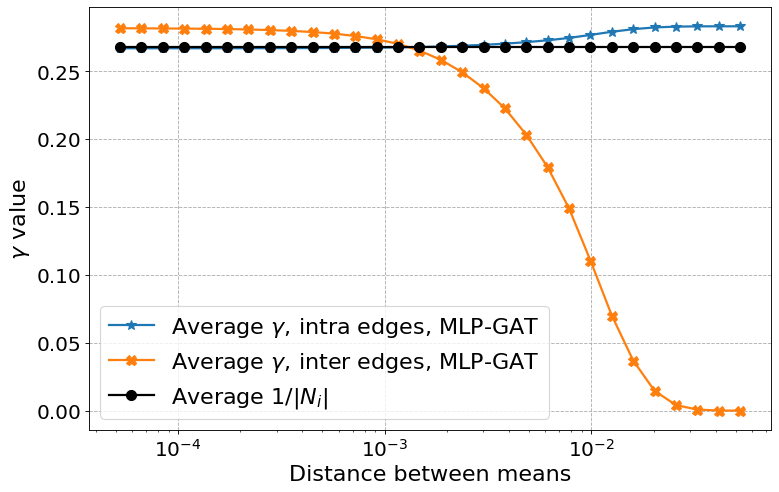

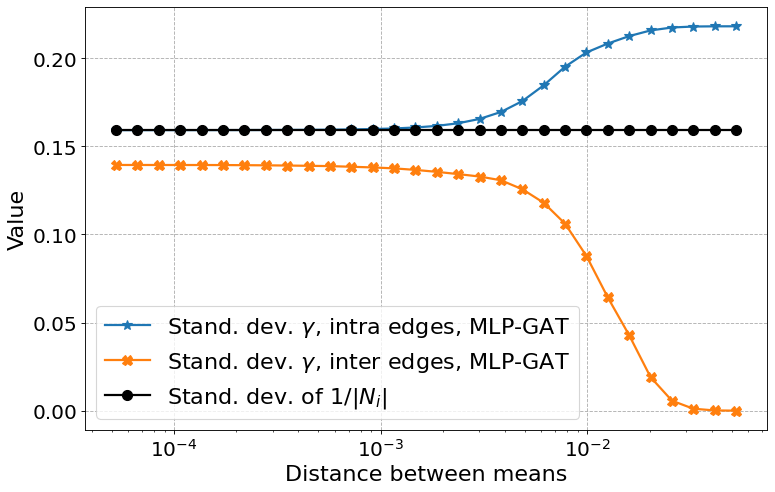

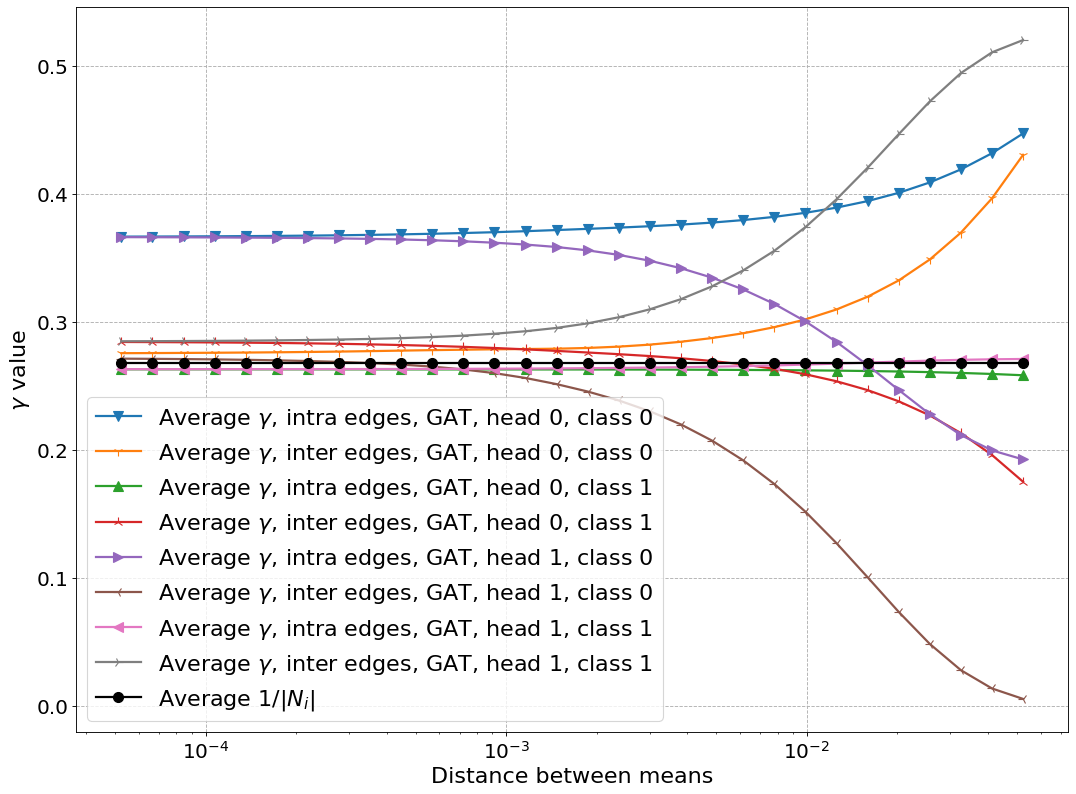

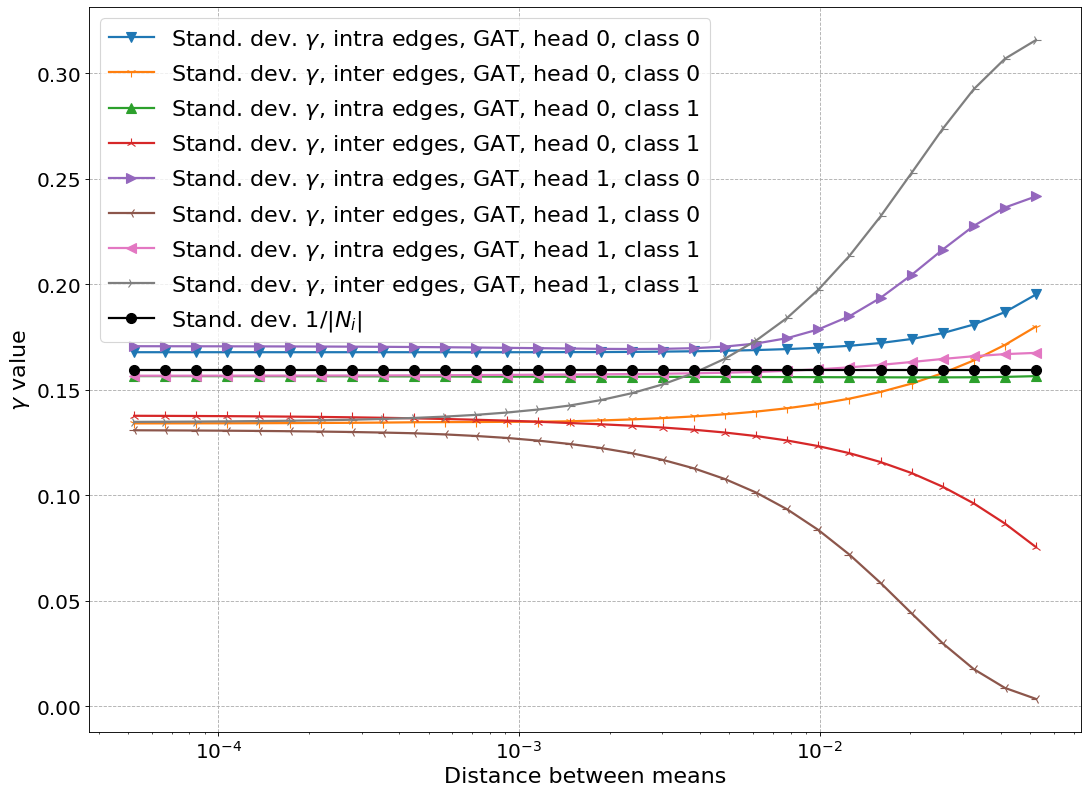

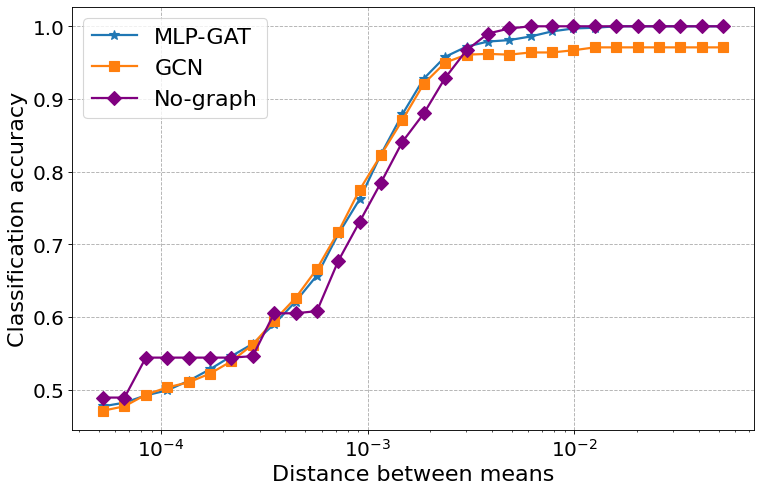

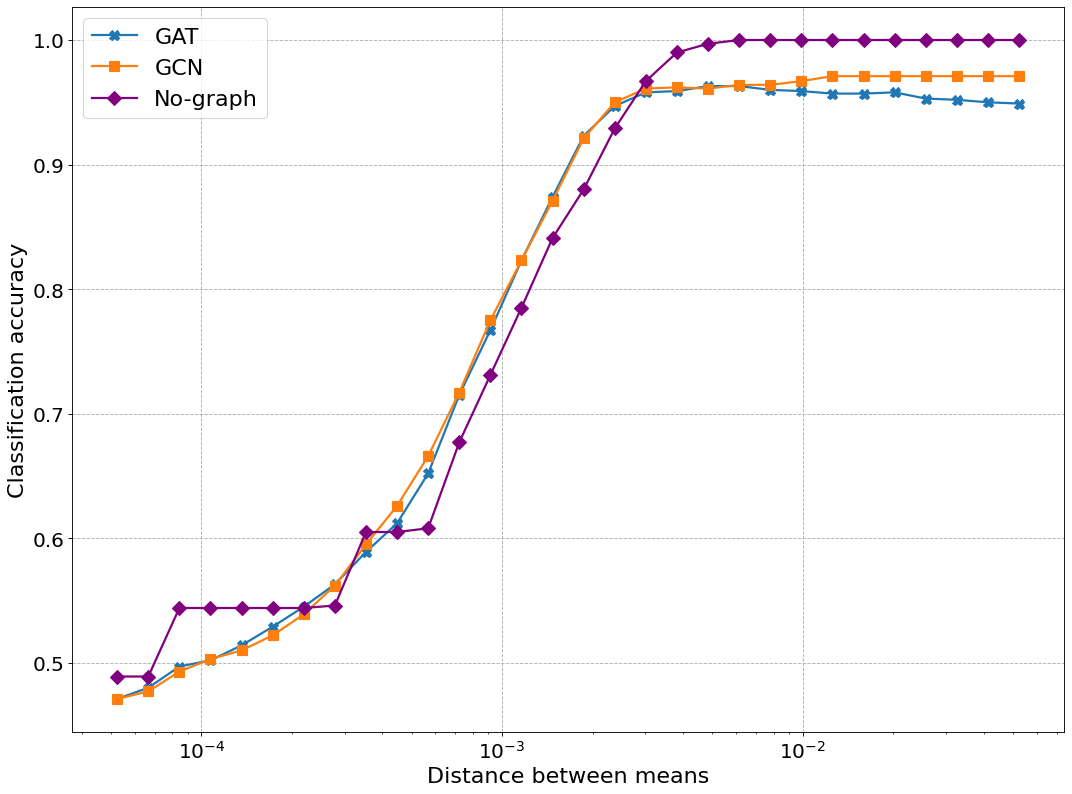

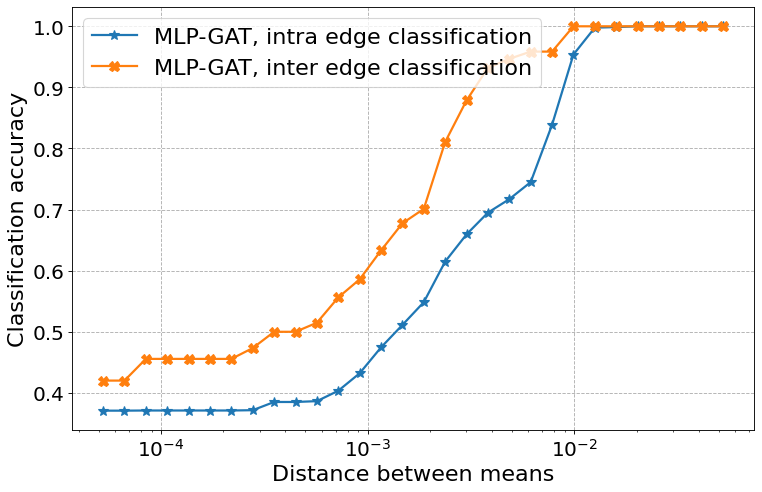

Class:  1
mu/max(mus) tensor(0.0010, dtype=torch.float64)
GCN,     Train: 0.5250 | Test: 0.4840
Linear,  Train: 0.5583 | Test: 0.4660
torch.Size([3327, 3703]) torch.Size([2, 9104]) torch.Size([9104, 4])
shapes torch.Size([12431, 4]) torch.Size([12431, 4])
MLP GAT ansatz, Train: 0.5000 | Test: 0.4800
Head:  0  acc intra edges:  0.3673129081726074  acc inter edges:  0.4437984228134155
GAT ansatz, Train: 0.5000 | Test: 0.4770
mu/max(mus) tensor(0.0013, dtype=torch.float64)
GCN,     Train: 0.5250 | Test: 0.4880
Linear,  Train: 0.5583 | Test: 0.4660
torch.Size([3327, 3703]) torch.Size([2, 9104]) torch.Size([9104, 4])
shapes torch.Size([12431, 4]) torch.Size([12431, 4])
MLP GAT ansatz, Train: 0.5083 | Test: 0.4860
Head:  0  acc intra edges:  0.3673129081726074  acc inter edges:  0.4437984228134155
GAT ansatz, Train: 0.5083 | Test: 0.4860
mu/max(mus) tensor(0.0016, dtype=torch.float64)
GCN,     Train: 0.5250 | Test: 0.4990
Linear,  Train: 0.5583 | Test: 0.4660
torch.Size([3327, 3703]) torch.S

In [ ]:
for dataset in datasets:
    print(dataset.name)
    data = dataset[0].to(device)
    n_classes = data.y.max() + 1
    print("Number of classes: ", n_classes)
    n = data.y.shape[0]
    data.x_backup = copy.deepcopy(data.x) 
    degree = torch_geometric.utils.degree(data.edge_index[1], n)
    
    print (data.edge_index.shape, data.x.shape)
    
    for which_class in range(n_classes):
        print("Class: ", which_class)
        y = torch.zeros(n, dtype=torch.float64).to(device)
        idx = data.y == which_class
        y[idx] = 1
        data.ynew = y
        
#         data.x = data.x.to(torch.float64)
        
        mean0 = data.x_backup[idx].mean(dim=0)
        mean1 = data.x_backup[~idx].mean(dim=0)
        
        distance = torch.norm(mean0-mean1)
        mu = distance/(2*torch.sqrt(torch.tensor(data.x.shape[1])))
        
        mu_up = 10*mu
        mu_lb = 0.01*mu

        mus = torch.tensor(np.geomspace(mu_lb.item(), mu_up.item(), 30, endpoint=True)).to(device)
        
        test_acc_mlp_gat = []
        test_acc_gat = []
        test_acc_gcn = []
        test_acc_lin = []
        intra_gamma = []
        inter_gamma = []
        intra_gamma_std = []
        inter_gamma_std = []
        acc_intra_edges_all = []
        acc_inter_edges_all = []
        intra_gamma_ = []
        inter_gamma_ = []
        intra_gamma_std_ = []
        inter_gamma_std_ = []
        acc_intra_edges_all_ = []
        acc_inter_edges_all_ = []
        
        heads = 2
        for head in range(heads):
            intra_gamma_.append([[],[]])
            inter_gamma_.append([[],[]])
            intra_gamma_std_.append([[],[]])
            inter_gamma_std_.append([[],[]])
            acc_intra_edges_all_.append([])
            acc_inter_edges_all_.append([])
            
        for mu_ in mus:
            
            print("mu/max(mus)", mu_/max(mus))
        
            new_mean0 = mu_*torch.ones(data.x.shape[1]).to(device)
            new_mean1 = -mu_*torch.ones(data.x.shape[1]).to(device)

            data.x[idx] = data.x_backup[idx] - mean0 + new_mean0
            data.x[~idx] = data.x_backup[~idx] - mean1 + new_mean1

            model_gcn_ansatz = create_ansatz_gcn(Model_GCN(data.x.shape[1], out_d=1).to(device), new_mean0, 1)
            train_acc, test_acc = measure_accuracy(model_gcn_ansatz, data)
            print(f"GCN,     Train: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_gcn.append(test_acc)

            model_linear_ansatz = create_ansatz_linear(Model_linear(data.x.shape[1], out_d=1).to(device), new_mean0, 1)
            train_acc, test_acc = measure_accuracy(model_linear_ansatz, data)
            print(f"Linear,  Train: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_lin.append(test_acc)
            
            model_mlp_gat_ansatz = create_ansatz_mlp_gat(Model_MLP_GAT(data.x.shape[1], out_d=1).to(device), new_mean0, 1)
            train_acc, test_acc, attn_weights, pair_pred = measure_accuracy_gat(model_mlp_gat_ansatz, data)
            print(f"MLP GAT ansatz, Train: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_mlp_gat.append(test_acc)
            
            intra_weight, idx_intra, inter_weight, idx_inter = info_mlp_gat(attn_weights, idx, 0)
            intra_gamma.append(np.asarray(intra_weight).mean())
            inter_gamma.append(np.asarray(inter_weight).mean())
            intra_gamma_std.append(np.asarray(intra_weight).std())
            inter_gamma_std.append(np.asarray(inter_weight).std())
            acc_intra_edges, acc_inter_edges = pair_acc(attn_weights[0][0].shape[0], pair_pred, idx_intra, idx_inter, 0)
            acc_intra_edges_all.append(acc_intra_edges.cpu())
            acc_inter_edges_all.append(acc_inter_edges.cpu())
            
            model_gat_ansatz = create_ansatz_gat(Model_GAT(data.x.shape[1], out_d=1, K=heads).to(device), new_mean0, 1)
            train_acc, test_acc, attn_weights, pair_pred = measure_accuracy_gat(model_gat_ansatz, data)
            print(f"GAT ansatz, Train: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_gat.append(test_acc)
            
            for head in range(heads):
                intra_weight, idx_intra, inter_weight, idx_inter = info_gat(attn_weights, idx, head)
#                 acc_intra_edges, acc_inter_edges = pair_acc(attn_weights[0][0].shape[0], pair_pred, idx_intra, idx_inter, head)
#                 acc_intra_edges_all_[head].append(acc_intra_edges.cpu())
#                 acc_inter_edges_all_[head].append(acc_inter_edges.cpu())
                for class_ in range(2):
                    intra_gamma_[head][class_].append(np.asarray(intra_weight[class_]).mean())
                    inter_gamma_[head][class_].append(np.asarray(inter_weight[class_]).mean())
                    intra_gamma_std_[head][class_].append(np.asarray(intra_weight[class_]).std())
                    inter_gamma_std_[head][class_].append(np.asarray(inter_weight[class_]).std())
        #             my_plot_violin(intra_weight, inter_weight)    
            
        my_plot(dataset.name, which_class, heads, mus, degree, intra_gamma, inter_gamma, intra_gamma_, inter_gamma_, 
                intra_gamma_std, inter_gamma_std, intra_gamma_std_, inter_gamma_std_, 
                test_acc_mlp_gat, test_acc_gat, test_acc_gcn, test_acc_lin, 
                acc_intra_edges_all, acc_inter_edges_all, acc_intra_edges_all_, acc_inter_edges_all_)
        

In [ ]:
print ("hello")